# Objective
Predict the energy throughput ratio of each frequency regulartion for each 5 minute interval during Feb 21-28.
1. Regulation throughput ratio = abs(average power) / regulation capacity award. A resource that averages 5MW (discharging) during an hour with a market award of 10MW Regulation Raise would have a 50% Raise Regulation Throughput Ratio. (5MW/10MW=50%)

#### Ratio implications ####
- If the throughput ratio is high, then the energy intensity of providing regulation is high
- A traditional energy award is a throughput ratio of 1. 

#### Tasks ####
1. Clean and prepare data
<p> Eliminate any obvious outlier frequency values</p>
<p> transform the 1 second frequency data in to 2 new columns. 5 minute average and 5 minute median</p>
2. Analyze data and summarize key observations
3. Prediction model
<p> why did you choose this model </p>
<p> Did you consider any other methods</p>
<p> predict regulation raise and lower throughput ratios for the last week in Feb</p>
<p> forecast in csv and include summary visuals</p>
<p> list the features and why you selected them</p>
<p> attach code</p>
<p> how would you describe the effectiveness</p>
<p> what other data would you want?</p>

## Imports

In [67]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import timeseries_helpers as th
import numpy as np
sns.set()

## 1. Clean and prepare the data
What does the data look like?

In [2]:
freq_df = pd.read_csv('frequency.csv')
freq_df.head(2)

,Timestamp (GMT),Frequency (Hz)
0,1514728800001,50.0
1,1514728801001,50.0


# Taks 1A eliminate any obvious outliers. 
Plan: 
1. Plot the frequency over time and look for outliers
2. Remove data points that are more than 4 standard deviations away

In [3]:
freq_df['utc_date'] = pd.to_datetime(freq_df['Timestamp (GMT)'], unit='ms')
freq_df.index = freq_df.utc_date
freq_df.index = freq_df.index.tz_localize('UTC')
freq_df.index = freq_df.index.tz_convert('Australia/Sydney')

(49.7, 50.5)

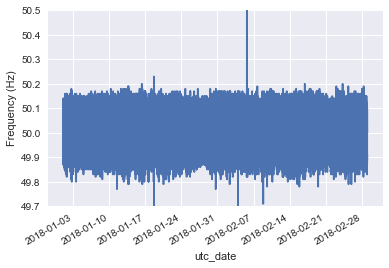

In [4]:
axs = freq_df['Frequency (Hz)'].plot()
axs.set_ylabel('Frequency (Hz)')
axs.set_ylim(49.7, 50.5)

It does not look like the variance is changing over time so no need to account for heteroskedacity

Text(0,0.5,'Number of occurrences')

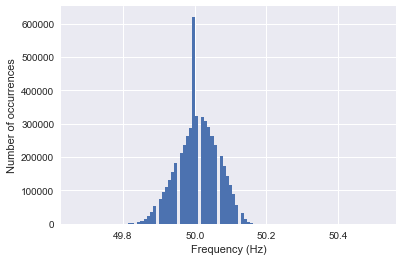

In [5]:
ax2 = freq_df['Frequency (Hz)'].plot(kind='hist', bins=100)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Number of occurrences')

It is interesting that there is one bin in the histogram that has nearly double the number of occurrences. Perhaps it's a default value in the frequency measurement system. I would ask for more information to determine if that value is physically meaningful.

In [6]:
freq_sd = freq_df['Frequency (Hz)'].std()
freq_mean = freq_df['Frequency (Hz)'].mean()

(49.7, 50.5)

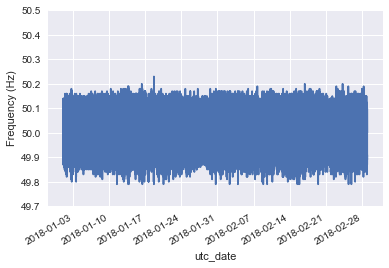

In [7]:
freq_df = freq_df.loc[((freq_mean - 4*freq_sd) < freq_df['Frequency (Hz)']) &
                              (freq_df['Frequency (Hz)'] < (freq_mean + 4*freq_sd))]
axs = freq_df['Frequency (Hz)'].plot()
axs.set_ylabel('Frequency (Hz)')
axs.set_ylim(49.7, 50.5)

### Task 1B:
Convert 1 second frequnecy data into 5 minute average values and 5 minute median values

In [8]:
five_min_mean = freq_df.resample('5T').mean()
del five_min_mean['Timestamp (GMT)']

In [9]:
def mean_resampler(array_like):
    return np.median(array_like)

In [10]:
five_min_median = freq_df.resample('5T').apply(mean_resampler)
del five_min_median['Timestamp (GMT)']

In [11]:
five_min_mean = five_min_mean.\
                    rename(columns={'Frequency (Hz)': '5_min_mean_freq_hz'})
five_min_median = five_min_median.\
                rename(columns={'Frequency (Hz)': '5_min_median_freq_hz'})

In [12]:
five_min_mean.columns

Index(['5_min_mean_freq_hz'], dtype='object')

In [13]:
downsampled_df = five_min_mean.join(five_min_median)
downsampled_df.head()

,5_min_mean_freq_hz,5_min_median_freq_hz
utc_date,,
2018-01-01 01:00:00+11:00,49.988900,49.990002
2018-01-01 01:05:00+11:00,50.056733,50.060001
2018-01-01 01:10:00+11:00,50.063867,50.070000
2018-01-01 01:15:00+11:00,50.016600,50.020000
2018-01-01 01:20:00+11:00,50.020767,50.009998


## Analyze the data set

In [14]:
ratio_df = pd.read_csv('throughput_ratio.csv')
ratio_df.head(2)

,Interval Ending (AEST),Raise Throughput Ratio,Lower Throughput Ratio
0,1/1/18 0:05,NaN,NaN
1,1/1/18 0:10,0.224593,NaN


In [15]:
generation_df = pd.read_csv('wind_generation.csv')
generation_df.head(2)

,Interval Ending (AEST),BLUFF1,CLEMGPWF,HALLWF1,HALLWF2,HDWF1,HDWF2,HDWF3,LKBONNY2,LKBONNY3,NBHWF1,SNOWNTH1,SNOWSTH1,SNOWTWN1,TRLWF,WATERLWF
0,1/1/18 0:05,13.1,2.95344,10.74,10.54,24.4,13.1,17.7,51.98349,9.88050,21.2,16.1,9.5,14.87030,12.15719,12.4
1,1/1/18 0:10,11.9,3.24158,13.01,10.33,22.2,13.9,17.9,42.13140,10.27125,21.7,14.9,8.6,13.64382,11.68275,11.9


It appears that the generation data and the throughput ratio awards have the same time axis, it makes sense to join the data.

In [16]:
df = ratio_df.merge(generation_df, how='inner', on='Interval Ending (AEST)')
df['Interval Ending (AEST)'] = df['Interval Ending (AEST)'].\
                                apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y %H:%M'))

In [17]:
df.index = df['Interval Ending (AEST)']

In [18]:
df.index = df.index.tz_localize('Australia/Sydney')

In [19]:
df = df.join(downsampled_df)

Sample the first two days in January to get a close look at what is going on

In [20]:
df.tail(2)

,Interval Ending (AEST),Raise Throughput Ratio,Lower Throughput Ratio,BLUFF1,CLEMGPWF,HALLWF1,HALLWF2,HDWF1,HDWF2,HDWF3,LKBONNY2,LKBONNY3,NBHWF1,SNOWNTH1,SNOWSTH1,SNOWTWN1,TRLWF,WATERLWF,5_min_mean_freq_hz,5_min_median_freq_hz
Interval Ending (AEST),,,,,,,,,,,,,,,,,,,,
2018-02-20 12:55:00+00:00,2018-02-20 23:55:00,0.274953,NaN,15.9,49.92027,33.59,26.41,34.8,42.4,43.2,53.64659,14.06715,58.5,73.4,59.0,69.04099,1.65681,32.7,49.998833,50.000000
2018-02-20 13:00:00+00:00,2018-02-21 00:00:00,0.341490,NaN,17.3,45.23799,35.17,28.37,33.1,40.9,39.2,54.37209,15.85345,58.6,62.0,52.1,59.50018,1.65681,31.7,49.945900,49.950001


In [21]:
sample = df.loc[df['Interval Ending (AEST)'] < datetime.date(2018, 1, 3)]

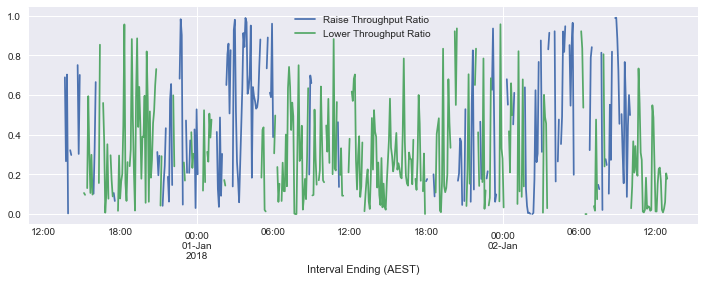

In [22]:
sample[['Raise Throughput Ratio', 'Lower Throughput Ratio']].plot(figsize=(12, 4))

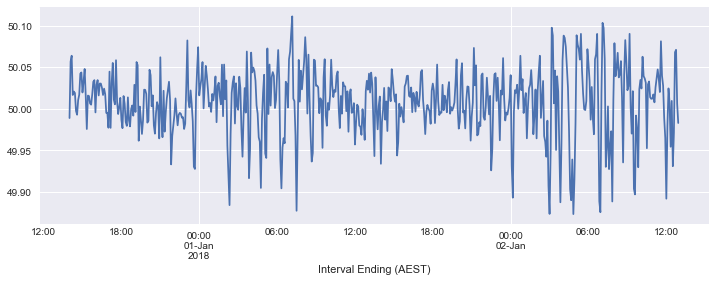

In [23]:
sample['5_min_mean_freq_hz'].plot(figsize=(12,4))

#### Part 2a: Observations
- The frequency data had holes for several values of frequency. This could be caused by a firmware issue. The impact to the model is likely small since the data is being low-pass filtered; but, it could have implications for the battery hardware
- It looks like there is a clear increase in wind power in the evenings starting at 5pm. Which is followed by more lower throughput ratio
- The periodicity of the data is approximately one day
- The signal that we are trying to predict appears to be stationary. Meaning that it is not tredning up or down. We can set the ARIMA d=0

## Model


The benefit of this model is that the model has 

Candidate models:
- Linear regression
- 

Plan:
- use model
- evaluate results on second to last week

I will merge the raise throughput ratio and lower throughput ratio into one column where the lower throughput ratio is a negative value. This will make predictions a little easier

In [24]:
def condense_ratio(row):
    if (np.isnan(row['Raise Throughput Ratio'])) & (np.isnan(row['Lower Throughput Ratio'])):
        result = 0
    elif np.isnan(row['Raise Throughput Ratio']):
        result = row['Lower Throughput Ratio'] * (-1)
    else:
        result = row['Raise Throughput Ratio']
    return result

In [25]:
df['output'] = df.apply(condense_ratio, axis=1)

In [26]:
df.head(2)

,Interval Ending (AEST),Raise Throughput Ratio,Lower Throughput Ratio,BLUFF1,CLEMGPWF,HALLWF1,HALLWF2,HDWF1,HDWF2,HDWF3,...,LKBONNY3,NBHWF1,SNOWNTH1,SNOWSTH1,SNOWTWN1,TRLWF,WATERLWF,5_min_mean_freq_hz,5_min_median_freq_hz,output
Interval Ending (AEST),,,,,,,,,,,,,,,,,,,,,
2017-12-31 13:05:00+00:00,2018-01-01 00:05:00,NaN,NaN,13.1,2.95344,10.74,10.54,24.4,13.1,17.7,...,9.88050,21.2,16.1,9.5,14.87030,12.15719,12.4,NaN,NaN,0.000000
2017-12-31 13:10:00+00:00,2018-01-01 00:10:00,0.224593,NaN,11.9,3.24158,13.01,10.33,22.2,13.9,17.9,...,10.27125,21.7,14.9,8.6,13.64382,11.68275,11.9,NaN,NaN,0.224593


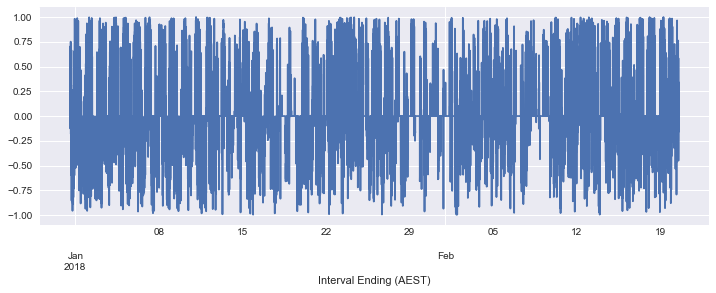

In [27]:
df.output.plot(figsize=(12,4))

In [28]:
model_df = df.drop(['Raise Throughput Ratio', 'Interval Ending (AEST)', 'Lower Throughput Ratio'],
                  axis=1)
model_df.to_csv('cleaned_ratio_data.csv')

In [29]:
import dateutil.parser

In [30]:
train_df = model_df.loc[model_df.index < dateutil.parser.parse('2018-02-01')]

In [95]:
cv_df = model_df.loc[(model_df.index > dateutil.parser.parse('2018-02-01')) &
                     (model_df.index < dateutil.parser.parse('2018-02-10'))
                    ]

In [32]:
test_df = model_df.loc[(model_df.index > dateutil.parser.parse('2018-02-10'))]

## Model

### ARIMA model
Autoregressive integrated moving average. The parameters of the model are:
- p: the number of lag observations in autoregression. (TBD)
- d: the number of times the raw observations are differenced. My initial guess is 0 because the output is already stationary. 
- q: the size of the moving average window. Initial guess is 0 

In [34]:
from statsmodels.tsa.arima_model import ARIMA

/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Find the number of lag observations by looking at the autoregression of the output.

In [35]:
from pandas.plotting import autocorrelation_plot

(-0.3, 0.3)

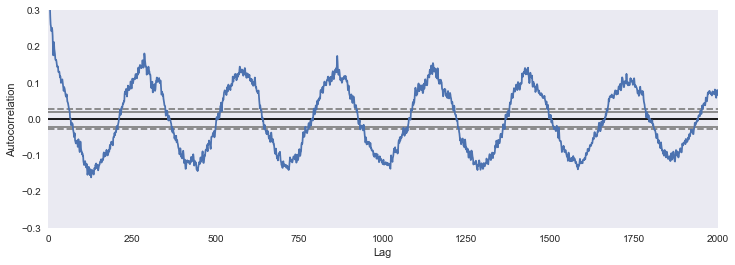

In [36]:
plt.figure(figsize=(12, 4))
axs = autocorrelation_plot(train_df.output)
axs.set_xlim(0,2000)
axs.set_ylim(-0.3,0.3)

(0, 100)

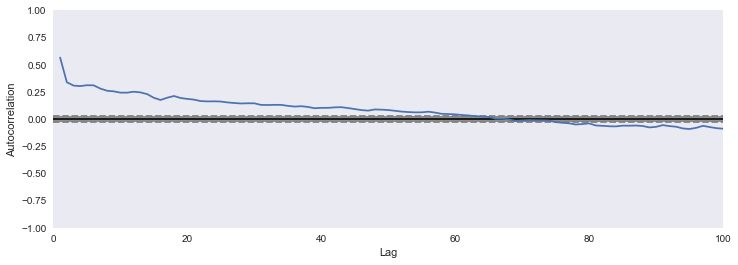

In [37]:
plt.figure(figsize=(12, 4))
axs = autocorrelation_plot(train_df.output)
axs.set_xlim(0,100)

In [38]:
model = ARIMA(train_df.output, order=(2,0,2))
model_fit = model.fit()

/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


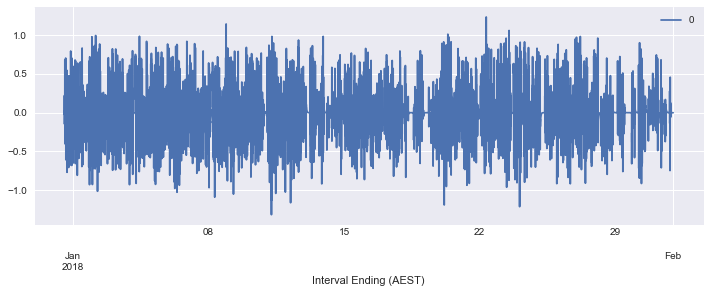

In [40]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12,4))

In [41]:
residuals.apply(lambda x: abs(x)).mean()

0    0.188488
dtype: float64

In [42]:
train_df.columns[:-1]

Index(['BLUFF1', 'CLEMGPWF', 'HALLWF1', 'HALLWF2', 'HDWF1', 'HDWF2', 'HDWF3',
       'LKBONNY2', 'LKBONNY3', 'NBHWF1', 'SNOWNTH1', 'SNOWSTH1', 'SNOWTWN1',
       'TRLWF', 'WATERLWF', '5_min_mean_freq_hz', '5_min_median_freq_hz'],
      dtype='object')

In [43]:
model = ARIMA(train_df.output, order=(2,0,2), exog=train_df[train_df.columns[:-3]])


/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/isachsquintana/Documents/markets_challenge/v3/

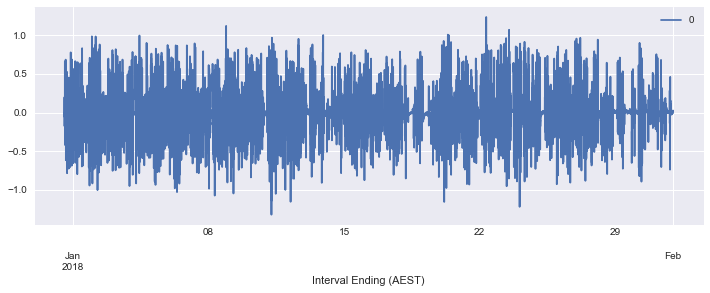

In [44]:
model_fit = model.fit()
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12,4))

In [45]:
residuals.apply(lambda x: abs(x)).mean()

0    0.189968
dtype: float64

In [46]:
import statsmodels.tsa.kalmanf as kalman

## 

## General Additive Model
$y(t) = g(t) + s(t) + h(t) + \epsilon_t$
- g represents non-periodic changes
- s represents periodic changes
- h represents holidays (will set to 0)
An implementation of this already exists in Facebook's prophet module so let's use that

In [49]:
from fbprophet import Prophet

In [ ]:
def prophet_style_df

In [50]:
model = Prophet(changepoints=None, 
                yearly_seasonality=False, 
                weekly_seasonality=False,
                daily_seasonality=True,
                seasonality_prior_scale=10,
                uncertainty_samples=10)

In [51]:
prophet_df = train_df
prophet_df = train_df.rename({'output': 'y'}, axis=1)
prophet_df['ds'] = prophet_df.index
prophet_df = prophet_df[['ds', 'y']]
prophet_df = prophet_df.reset_index()
prophet_df = prophet_df.drop(['Interval Ending (AEST)'], axis=1)
prophet_df['ds'] = prophet_df.ds.dt.tz_localize(None)

prophet_df.head(2)

,ds,y
0,2017-12-31 13:05:00,0.000000
1,2017-12-31 13:10:00,0.224593


In [52]:
model.fit(prophet_df)

/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [53]:
training_fit = model.predict()

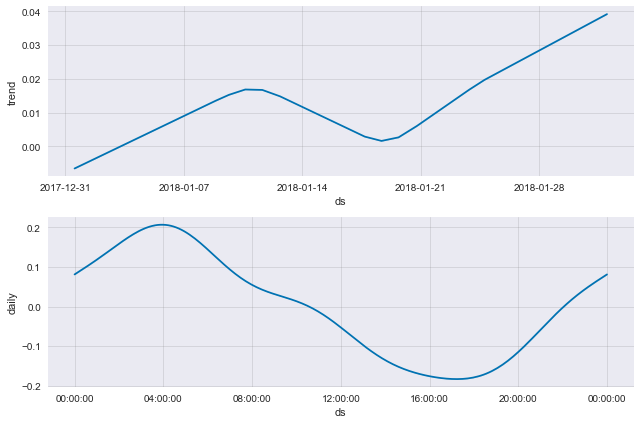

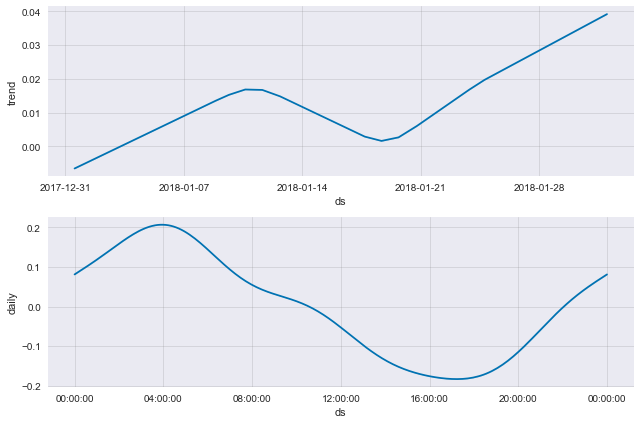

In [54]:
model.plot_components(training_fit)

In [55]:
residual_df = training_fit.join(prophet_df, how='inner', lsuffix=('_fit'))
residual_df['residual'] = residual_df.y - residual_df.yhat
residual_df.residual.apply(lambda x: abs(x)).mean()

0.23947821827212018

In [57]:
cv_df['ds'] = cv_df.index

/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
def make_df_prophet_ready(df):
    """
    Strips the timezone and renames the timezone ds. The function assumes that
    the time column is the index of the pandas dataframe
    Args:
        df (pandas DataFrame): dataframe with time column as the index
    """
    index_col_name = df.index.name
    df['ds'] = df.index
    df = df.reset_index()
    df = df.drop([index_col_name], axis=1)
    df['ds'] = df.ds.dt.tz_localize(None)
    return df

In [101]:
fb_cv_df = make_df_prophet_ready(cv_df)
fb_cv_df.head(2)

/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,BLUFF1,CLEMGPWF,HALLWF1,HALLWF2,HDWF1,HDWF2,HDWF3,LKBONNY2,LKBONNY3,NBHWF1,SNOWNTH1,SNOWSTH1,SNOWTWN1,TRLWF,WATERLWF,5_min_mean_freq_hz,5_min_median_freq_hz,output,ds
0,14.445,43.400,0.862,22.563,48.419,55.313,50.395,117.855,31.774,67.044,60.511,84.717,75.136,30.725,65.220,49.998467,50.000000,0.000000,2018-02-01 00:05:00
1,14.349,41.667,23.785,25.258,47.128,55.598,50.284,119.682,30.316,72.440,65.619,84.722,67.805,21.396,56.023,50.016700,50.009998,0.337915,2018-02-01 00:10:00


In [112]:
fb_cv_predicitons = model.predict(fb_cv_df)

In [117]:
fb_cv_predicitons.index = fb_cv_predicitons['ds']
cv_residual_df = fb_cv_df.merge(fb_cv_predicitons, how='inner', on='ds')
cv_residual_df.index = cv_residual_df.ds

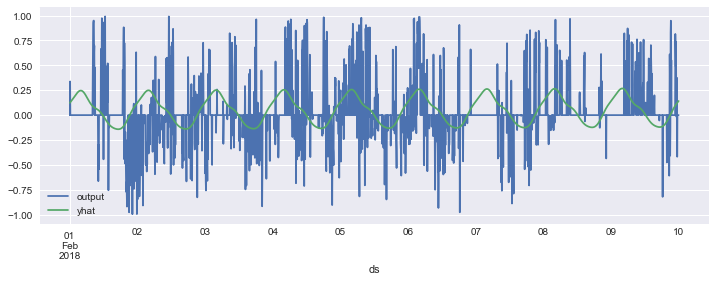

In [120]:
cv_residual_df[['output', 'yhat']].plot(figsize=(12,4))

In [122]:
cv_residual_df['sq_err'] = (cv_residual_df.output - cv_residual_df.yhat)**2
cv_residual_df.sq_err.mean()

0.08527610943992772

In [123]:
abs(cv_residual_df.output - cv_residual_df.yhat).mean()

0.21362225199945103

In [124]:
abs(cv_residual_df.output).mean()

0.13457334156696257

In [125]:
bet_zero = (cv_residual_df.output)**2
bet_zero.mean()

0.07464828732448399